In [2]:
import torch
import os
from torch import nn 
import numpy as np 
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.utils.data import random_split

In [10]:
#查看数据集

poem_path='tang.npz'
embedding_dim=100
hidden_dim=1024
lr=0.001
LSTM_layers=3


datas = np.load(poem_path,allow_pickle=True)
data = datas['data']
ix2word = datas['ix2word'].item()
word2ix = datas['word2ix'].item()

#显示指定诗的前多少字
def view_poem(length,x):
    y=np.zeros((1,length),dtype=np.str)
    for i in range(length):
        y[0,i] = ix2word[x[i]]
    print(y)

view_poem(125,data[2])

[['<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<'
  '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<'
  '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '<' '川' '上'
  '风' '雨' '来' '，' '须' '臾' '满' '城' '阙' '。' '岧' '峣' '青' '莲' '界' '，' '萧' '条'
  '孤' '兴' '发' '。' '前' '山' '遽' '已' '净' '，' '阴' '霭' '夜' '来' '歇' '。' '乔' '木'
  '生' '夏' '凉' '，' '流' '云' '吐' '华' '月' '。' '严' '城' '自' '有' '限' '，' '一' '水'
  '非' '难' '越' '。' '相' '望' '曙' '河' '远' '，' '高' '斋' '坐' '超' '忽' '。' '<']]


In [3]:
#构造数据集
class Poem(Dataset):
    def __init__(self,poem_path,seq_len):
        self.seq_len = seq_len
        self.poem_path = poem_path
        self.poem_data, self.ix2word, self.word2ix = self.get_raw_data()
        self.no_space_data = self.filter_space()

    def __getitem__(self, idx:int):
        txt = self.no_space_data[idx : idx+self.seq_len]
        label = self.no_space_data[idx + 1 : idx+self.seq_len + 1]
        txt = torch.from_numpy(np.array(txt)).long()
        label = torch.from_numpy(np.array(label)).long()
        return txt,label

    def __len__(self):
        return len(self.no_space_data) -self.seq_len+1

    def filter_space(self): # 将空格的数据给过滤掉，并将原始数据平整到一维
        t_data = torch.from_numpy(self.poem_data).view(-1)
        flat_data = t_data.numpy()
        no_space_data = []
        for i in flat_data:
            if (i != 8292 ):
                no_space_data.append(i)
        return no_space_data
    
    def get_raw_data(self):
        datas = np.load(self.poem_path,allow_pickle=True)
        data = datas['data']
        ix2word = datas['ix2word'].item()
        word2ix = datas['word2ix'].item()
        return data, ix2word, word2ix

In [4]:
#制作好的数据集
#view_poemtensor版本
def view_poem(length,x):
    y=np.zeros((1,length),dtype=np.str)
    for i in range(length):
        y[0,i] = ix2word[x[i].item()]
    print(y)
    
    
poem_ds = Poem(poem_path, 48)

view_poem(len(poem_ds[20][0]),poem_ds[20][0])
view_poem(len(poem_ds[20][1]),poem_ds[20][1])

#制成一个loader

train_ds,val_ds=random_split(poem_ds,[60000,len(poem_ds)-60000])
train_loader=DataLoader(train_ds,batch_size=50,shuffle=True,drop_last=True)
val_loader=DataLoader(val_ds,batch_size=50,shuffle=True,drop_last=True)

[['怜' '马' '似' '骢' '。' '乍' '迷' '金' '谷' '路' '，' '稍' '变' '上' '阳' '宫' '。' '还'
  '比' '相' '思' '意' '，' '纷' '纷' '正' '满' '空' '。' '<' '<' '逍' '遥' '东' '城' '隅'
  '，' '双' '树' '寒' '葱' '蒨' '。' '广' '庭' '流' '华' '月']]
[['马' '似' '骢' '。' '乍' '迷' '金' '谷' '路' '，' '稍' '变' '上' '阳' '宫' '。' '还' '比'
  '相' '思' '意' '，' '纷' '纷' '正' '满' '空' '。' '<' '<' '逍' '遥' '东' '城' '隅' '，'
  '双' '树' '寒' '葱' '蒨' '。' '广' '庭' '流' '华' '月' '，']]


In [3]:
class PoemWrite(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim,num_layers):
        super(MyPoetryModel_tanh, self).__init__()
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True,dropout=0, bidirectional=False)
        self.fc1 = nn.Linear(hidden_dim,2048)
        self.fc2 = nn.Linear(2048,4096)
        self.fc3 = nn.Linear(4096,vocab_size)


    def forward(self, input, hidden=None):
        embeds = self.embeddings(input)
        batch_size, seq_len = input.size()
        if hidden is None:
            h_0 = input.data.new(self.num_layers, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = input.data.new(self.num_layers, batch_size, self.hidden_dim).fill_(0).float()
        else:
            h_0, c_0 = hidden
        output, hidden = self.lstm(embeds, (h_0, c_0))
        output = torch.tanh(self.fc1(output))
        output = torch.tanh(self.fc2(output))
        output = self.fc3(output)
        pred = torch.topk(output, 1, largest=True, sorted=True)[1]
        output = output.reshape(batch_size*seq_len,-1)
        return pred.view(-1),output,hidden
    
#input[batch_size,seq_len]    
    
#output[batch_size,seq_len,vocab_size]
#hidden--h_0,c_0  [layers,batch_size,hidden]

In [7]:
def accuracy(pred, label):
    length=len(pred)
    cnt = pred.eq(label).sum().item()
    return cnt/length

In [4]:
#只有一个input，每次手动把hidden和output放进下一个cell
def test(words,model,device):
    poem=list(words)
    words=list(words)
    words.insert(0,'<START>')

    length=len(words)
    if(length>=49):
        print('已经很长不用续写了(微笑)')
        return -1
      
    words=torch.tensor([word2ix[i] for i in words]).to(device)
    words=words.view(1,length)
  
  #已有的部分只要最后一个字的pred，和他的hidden
  #有两种不同的输入，只有输入和输入加hidden
    pred,_,hidden=model(words)

    for i in range(49-length):
        if ix2word[pred[-1].item()]!='<EOP>':
            poem.append(ix2word[pred[-1].item()])
            pred = pred[-1].view(1,1)
            pred,_,hidden=model(pred,hidden)

        else:
            return poem  #遇到截止符就停止
    
    return poem
    

In [8]:
#全局变量
answer1=[]
answer2=[]
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]


def train( epochs, train_loader,val_loader, device, model):
    quiz_1='接天莲叶无穷碧'
    quiz_2='会当凌绝顶'

    train_num=len(train_loader)
    val_num=len(val_loader)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), 0.001)
  
    for epoch in range(epochs):
        epoch_loss=0.0  #用于更新train__loss和train_acc
        epoch_acc=0.0

        model.train()
        
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            pred,outputs,hidden = model(inputs)

            labels=labels.view(-1)
            loss = torch.nn.functional.cross_entropy(outputs,labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += accuracy(pred, labels)

            if((i+1)%200==0):
                print(epoch,'th epoch ',i,'th train_ite ','train_loss:',loss.item(),'train_acc:',accuracy(pred,labels))

    train_loss.append(epoch_loss/train_num)
    train_acc.append(epoch_acc/train_num)

    
    #计算测试集
    epoch_loss=0.0  #用于更新val__loss和val_acc
    epoch_acc=0.0

    with torch.no_grad():
        model.eval()
        for i, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            pred,outputs,hidden = model(inputs)

            labels=labels.view(-1)
            loss = torch.nn.functional.cross_entropy(outputs,labels)
            epoch_loss += loss.item()
            epoch_acc += accuracy(pred, labels)
      
            if((i+1)%100==0):
                print(epoch,'th epoch ',i,'th val_ite ','val_loss:',loss.item(),'val_acc:',accuracy(pred,labels))

    val_loss.append(epoch_loss/val_num)
    val_acc.append(epoch_acc/val_num)
      
    #quiz
    a1=''.join(test(quiz_1,model,device))
    a2=''.join(test(quiz_2,model,device))
    print(a1)
    print(a2)
    answer1.append(a1)
    answer2.append(a2)


In [8]:
model=PoemWrite( len(word2ix), embedding_dim, hidden_dim,LSTM_layers)
model.load_state_dict(torch.load('7-epoch.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

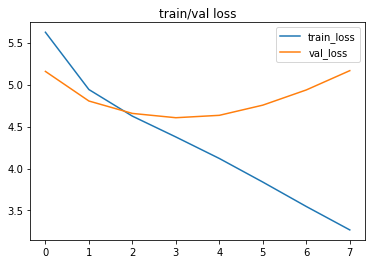

In [17]:
import matplotlib.pyplot as plt

train_acc=[0.19236250000000096,
0.23422465277777854,
0.2567996527777773,
0.27707638888888886,
0.30117986111111106,
0.33171388888888886,
0.3668829861111119,
0.4031659722222227]


val_acc=[0.2193412698412699,
0.24521428571428577,
0.25726587301587306,
0.26369444444444445,
0.26551587301587304,
0.263920634920635,
0.262063492063492,
0.25861904761904764]

train_loss=[5.624020807345708,
4.941127345164617,
4.624158886671066,
4.375943488279979,
4.119530411163966,
3.838339075247447,
3.5473141759634017,
3.268163660566012]

val_loss=[5.157280649457659,
4.804408740997315,
4.656552927834647,
4.605309286571685,
4.633861019497826,
4.75527393704369,
4.936451189858573,
5.166200151897612]

plt.title('train/val loss')
#plt.plot(train_acc)
plt.plot(train_loss)
#plt.plot(val_acc)
plt.plot(val_loss)
plt.legend(['train_loss','val_loss'])

In [15]:
x=test('细雨斜风作晓寒',model,'cpu')
y=''.join(x)
print(y)

细雨斜风作晓寒，轻罗带缕恨无违。不知惆怅花前散，一片残红隔水云。
